In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

In [3]:
import tensorflow as tf

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

/home/mjlucker/tensorflow/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/home/mjlucker/tensorflow/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/home/mjlucker/tensorflow/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/home/mjlucker/tensorflow/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is depre

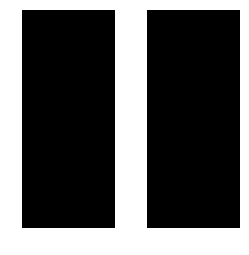

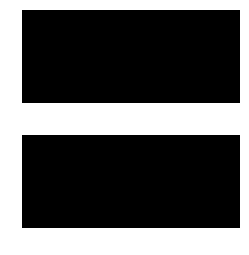

In [6]:
fmap = np.zeros(shape=(7,7,1,2), dtype=np.float32)
fmap[:,3,0,0] = 1
fmap[3,:,0,1] = 1
plot_image(fmap[:,:,0,0])
plt.show()
plot_image(fmap[:,:,0,1])
plt.show()

In [7]:
reset_graph()

with tf.device("/cpu:0"):
    X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
    feature_maps = tf.constant(fmap)
    convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding='SAME')

In [8]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

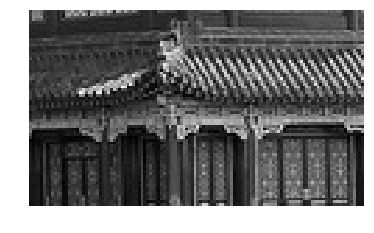

In [9]:
plot_image(images[0, :, :, 0])
plt.show()

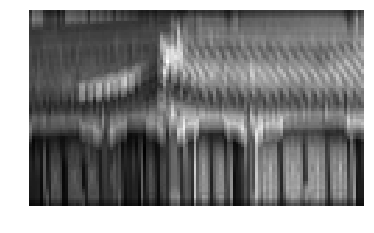

In [10]:
plot_image(output[0,:,:,0])
plt.show()

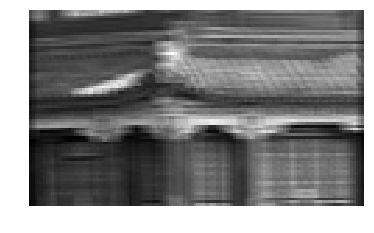

In [11]:
plot_image(output[0,:,:,1])
plt.show()

## Exercise Solutions

### Build CNN for MNIST

In [12]:
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [13]:
import tensorflow as tf

def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)


height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.5

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

reset_graph()

config = tf.ConfigProto()
config.allow_soft_placement = True


with tf.device("/cpu:0"):
    with tf.name_scope("inputs"):
    
        X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
        X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
        y = tf.placeholder(tf.int32, shape=[None], name="y")
        training = tf.placeholder_with_default(False, shape=[],
                                              name='training')
        
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, 
                            kernel_size=conv1_ksize, strides=conv1_stride,
                            padding=conv1_pad, activation=tf.nn.relu,
                            name="conv1")
    
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                             strides=conv2_stride, padding=conv2_pad,
                             activation=tf.nn.relu, name="conv2")
    
    with tf.name_scope("pool3"):
        pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1],
                              padding="VALID")
        pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps*14*14])
        pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate,
                                           training=training)

        
with tf.device("/gpu:0"):        
    with tf.name_scope("fc1"):
        fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu,
                             name="fc1")
        fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)
        
    with tf.name_scope("output"):
        logits = tf.layers.dense(fc1, n_outputs, name="output")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")
        
    with tf.name_scope("train"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(xentropy)
        optimizer = tf.train.AdamOptimizer()
        training_op = optimizer.minimize(loss)
        
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    with tf.name_scope("init_and_save"):
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        
loss_summary = tf.summary.scalar('Loss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [14]:
import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [15]:
n_epochs = 10
batch_size = 100

with tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 10 == 0:
                summary_str = loss_summary.eval(feed_dict={X: X_batch, 
                                                          y: y_batch})
                step = epoch * mnist.train.num_examples // batch_size + iteration
                file_writer.add_summary(summary_str, step)
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y:mnist.test.labels})
        
        print(epoch, "Train accuracy:" , acc_train, "Test accuracy: ", acc_test)
        
        save_path = saver.save(sess, "./my_CNN_mnist_model")

0 Train accuracy: 1.0 Test accuracy:  0.9851
1 Train accuracy: 0.99 Test accuracy:  0.981
2 Train accuracy: 0.99 Test accuracy:  0.9876
3 Train accuracy: 1.0 Test accuracy:  0.9878
4 Train accuracy: 1.0 Test accuracy:  0.988
5 Train accuracy: 1.0 Test accuracy:  0.9881
6 Train accuracy: 1.0 Test accuracy:  0.9901
7 Train accuracy: 1.0 Test accuracy:  0.9886
8 Train accuracy: 0.99 Test accuracy:  0.9836
9 Train accuracy: 1.0 Test accuracy:  0.9905


In [16]:
reset_graph()

## Recreate CNN to enable TensorBoard

In [18]:
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [19]:
import tensorflow as tf

def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)


def conv_layer(input, channels_in, channels_out, name):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([3,3,channels_in, channels_out],
                                           dtype=tf.float32, stddev=1e-1, name="W"))
        b = tf.Variable(tf.zeros([channels_out]), name="B")
        conv = tf.nn.conv2d(input, w, strides=[1,1,1,1], padding="SAME")
        act = tf.nn.relu(conv + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act
    
def fc_layer(input, channels_in, channels_out, name):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([channels_in, channels_out]), name="W")
        b = tf.Variable(tf.zeros([channels_out]), name="B")
        act = tf.nn.relu(tf.matmul(input,w) + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act

In [20]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv2_dropout_rate = 0.5

pool3_fmaps = 64

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

reset_graph()

config = tf.ConfigProto()
config.allow_soft_placement = True


with tf.device("/cpu:0"):
    with tf.name_scope("inputs"):
    
        X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
        X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
        y = tf.placeholder(tf.int32, shape=[None], name="y")
        training = tf.placeholder_with_default(False, shape=[],
                                              name='training')


    conv1 = conv_layer(X_reshaped, 1, 32, name="conv1")
    
    conv2 = conv_layer(conv1, 32, 64, name="conv2")
    
    with tf.name_scope("pool3"):
        pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1],
                              padding="VALID")
        pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps*14*14])
        pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate,
                                           training=training)
   

with tf.device("/gpu:0"): 
    with tf.name_scope("fc1"):
        fc1 = fc_layer(pool3_flat_drop, pool3_fmaps*14*14, n_fc1, name="fc1")
        fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)
        
    with tf.name_scope("output"):
        logits = tf.layers.dense(fc1, n_outputs, name="output")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")
        
    with tf.name_scope("train"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(xentropy)
        optimizer = tf.train.AdamOptimizer()
        training_op = optimizer.minimize(loss)
        variable_summaries(loss)
        
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    with tf.name_scope("init_and_save"):
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

In [21]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
loss_summary = tf.summary.scalar('Loss', loss)
#tf.summary.scalar('train', xentropy)
tf.summary.scalar('accuracy', accuracy)
tf.summary.image('input', X_reshaped, 3)
merged_summary = tf.summary.merge_all()

In [22]:
import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [23]:
import time

n_epochs = 10
batch_size = 100

with tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        start = time.time()
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 10 == 0:
                summary_str = sess.run(merged_summary, feed_dict={X: X_batch, 
                                                          y: y_batch})
                step = epoch * mnist.train.num_examples // batch_size + iteration
                file_writer.add_summary(summary_str, step)
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y:mnist.test.labels})
        
        print(epoch, "Train accuracy:" , acc_train, "Test accuracy: ", acc_test)
        end = time.time()
        print("Epoch runtime:", (end-start))
        
        save_path = saver.save(sess, "./my_CNN_mnist_model")

0 Train accuracy: 0.97 Test accuracy:  0.9603
Epoch runtime: 36.73369765281677
1 Train accuracy: 0.99 Test accuracy:  0.9723
Epoch runtime: 36.66897630691528
2 Train accuracy: 0.99 Test accuracy:  0.9775
Epoch runtime: 36.31705570220947
3 Train accuracy: 0.96 Test accuracy:  0.9791
Epoch runtime: 36.5116171836853
4 Train accuracy: 0.99 Test accuracy:  0.9828
Epoch runtime: 36.26374411582947
5 Train accuracy: 0.98 Test accuracy:  0.9848
Epoch runtime: 36.33560752868652
6 Train accuracy: 1.0 Test accuracy:  0.983
Epoch runtime: 36.35562252998352
7 Train accuracy: 1.0 Test accuracy:  0.9824
Epoch runtime: 36.149768352508545
8 Train accuracy: 0.99 Test accuracy:  0.9858
Epoch runtime: 36.28382992744446
9 Train accuracy: 1.0 Test accuracy:  0.9843
Epoch runtime: 35.975558042526245


In [43]:
reset_graph()

## Higher Accuracy CNN on MNIST

The following CNN is similar to the one defined above, except using stride 1 for the second convolutional layer (rather than 2), with 25% dropout after the second convolutional layer, 50% dropout after the fully connected layer, and trained using early stopping

In [44]:
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [45]:
import tensorflow as tf

def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)


def conv_layer(input, channels_in, channels_out, name):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([3,3,channels_in, channels_out],
                                           dtype=tf.float32, stddev=1e-1, name="W"))
        b = tf.Variable(tf.zeros([channels_out]), name="B")
        conv = tf.nn.conv2d(input, w, strides=[1,1,1,1], padding="SAME")
        act = tf.nn.relu(conv + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act
    
def fc_layer(input, channels_in, channels_out, name):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([channels_in, channels_out]), name="W")
        b = tf.Variable(tf.zeros([channels_out]), name="B")
        act = tf.nn.relu(tf.matmul(input,w) + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act

In [46]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv2_dropout_rate = 0.25

pool3_fmaps = 64

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

reset_graph()

config = tf.ConfigProto()
config.allow_soft_placement = True


with tf.device("/cpu:0"):
    with tf.name_scope("inputs"):
    
        X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
        X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
        y = tf.placeholder(tf.int32, shape=[None], name="y")
        training = tf.placeholder_with_default(False, shape=[],
                                              name='training')


    conv1 = conv_layer(X_reshaped, 1, 32, name="conv1")
    
    conv2 = conv_layer(conv1, 32, 64, name="conv2")
    
    with tf.name_scope("pool3"):
        pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,1,1,1],
                              padding="VALID")
        pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps*27*27])
        pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate,
                                           training=training)
   

with tf.device("/gpu:0"): 
    with tf.name_scope("fc1"):
        fc1 = fc_layer(pool3_flat_drop, pool3_fmaps*27*27, n_fc1, name="fc1")
        fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)
        
    with tf.name_scope("output"):
        logits = tf.layers.dense(fc1, n_outputs, name="output")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")
        
    with tf.name_scope("train"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(xentropy)
        optimizer = tf.train.AdamOptimizer()
        training_op = optimizer.minimize(loss)
        variable_summaries(loss)
        
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    with tf.name_scope("init_and_save"):
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

In [47]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
loss_summary = tf.summary.scalar('Loss', loss)
#tf.summary.scalar('train', xentropy)
tf.summary.scalar('accuracy', accuracy)
tf.summary.image('input', X_reshaped, 3)
merged_summary = tf.summary.merge_all()

In [48]:
import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The get_model_params() function gets the model's state (i.e., the value of all the variables), and the restore_model_params() restores a previous state. This is used to speed up early stopping: instead of storing the best model found so far to disk, we just save it to memory. At the end of training, we roll back to the best model found.

In [49]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)


    every 100 training iterations, it evaluates the model on the validation set,
    if the model performs better than the best model found so far, then it saves the model to RAM,
    if there is no progress for 100 evaluations in a row, then training is interrupted,
    after training, the code restores the best model found.

In [50]:
import time

n_epochs = 100
batch_size = 50

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 10
best_model_params = None

with tf.Session(config=config) as sess:
    init.run(session=sess)
    for epoch in range(n_epochs):
        start = time.time()
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % 10 == 0:
                summary_str = sess.run(merged_summary, feed_dict={X: X_batch, 
                                                          y: y_batch})
                step = epoch * mnist.train.num_examples // batch_size + iteration
                file_writer.add_summary(summary_str, step)
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: mnist.validation.images,
                                               y: mnist.validation.labels})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    check_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.test.images, y:mnist.test.labels})
        
        print(epoch, "Train accuracy:" , acc_train, "Test accuracy: ", acc_test,
             "best loss: ", best_loss_val, "checks_since_last_progress", 
             checks_since_last_progress)
        
        if checks_since_last_progress > max_checks_without_progress:
            print("Early Stopping!")
            break
            
        end = time.time()
        print("Epoch runtime:", (end-start))
        
    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                           y: mnist.test.labels})
    print("Final accuracy on test set:", acc_test)        
    save_path = saver.save(sess, "./my_CNN_mnist_model")

0 Train accuracy: 0.98 Test accuracy:  0.9843 best loss:  0.10527886 checks_since_last_progress 0
Epoch runtime: 80.51833748817444
1 Train accuracy: 0.98 Test accuracy:  0.9843 best loss:  0.06966074 checks_since_last_progress 0
Epoch runtime: 75.38063597679138
2 Train accuracy: 0.96 Test accuracy:  0.9843 best loss:  0.061838135 checks_since_last_progress 0
Epoch runtime: 73.79066967964172
3 Train accuracy: 1.0 Test accuracy:  0.9843 best loss:  0.05297064 checks_since_last_progress 1
Epoch runtime: 73.9297034740448
4 Train accuracy: 0.98 Test accuracy:  0.9843 best loss:  0.049550913 checks_since_last_progress 3
Epoch runtime: 73.96156883239746
5 Train accuracy: 1.0 Test accuracy:  0.9843 best loss:  0.049550913 checks_since_last_progress 6
Epoch runtime: 73.79215359687805
6 Train accuracy: 1.0 Test accuracy:  0.9843 best loss:  0.04657111 checks_since_last_progress 8
Epoch runtime: 73.67084407806396
7 Train accuracy: 1.0 Test accuracy:  0.9843 best loss:  0.04504638 checks_since_las

In [17]:
reset_graph()

## Classifying Large Images using Inception v3

Exercise: Download some images of various animals. Load them in Python, for example using the matplotlib.image.mpimg.imread() function or the scipy.misc.imread() function. Resize and/or crop them to 299 × 299 pixels, and ensure that they have just three channels (RGB), with no transparency channel. The images that the Inception model was trained on were preprocessed so that their values range from -1.0 to 1.0, so you must ensure that your images do too.

In [18]:
import matplotlib.image as mpimg
from PIL import Image
from skimage.transform import resize

test_image = mpimg.imread(os.path.join("Inception_test_images","cat.jpeg"))
test_image_resize = resize(test_image, (299,299), mode='constant')*2-1
print(test_image.shape)
print(test_image_resize.shape)
print(test_image_resize)

#plt.imshow(test_image_resize)
#plt.axis("off")
#plt.show()


(188, 268, 3)
(299, 299, 3)
[[[ 0.2899684   0.31419316  0.38686743]
  [ 0.36049577  0.38604499  0.46269264]
  [ 0.35576404  0.38131325  0.4579609 ]
  ...
  [ 0.11777821  0.11139091  0.08584169]
  [ 0.11777821  0.11139091  0.08584169]
  [ 0.05983319  0.053777    0.02955224]]

 [[ 0.5345539   0.56430011  0.65353875]
  [ 0.61845367  0.64982622  0.74394387]
  [ 0.61521821  0.64659076  0.74070841]
  ...
  [ 0.37254902  0.36470588  0.33333333]
  [ 0.37254902  0.36470588  0.33333333]
  [ 0.30139681  0.29396026  0.26421405]]

 [[ 0.46655545  0.49630166  0.5855403 ]
  [ 0.54626123  0.57763378  0.67175142]
  [ 0.54617352  0.57754607  0.67166372]
  ...
  [ 0.37254902  0.36470588  0.33333333]
  [ 0.37254902  0.36470588  0.33333333]
  [ 0.30139681  0.29396026  0.26421405]]

 ...

 [[ 0.048554    0.048554    0.048554  ]
  [ 0.11912912  0.11912912  0.11912912]
  [ 0.13899928  0.13899928  0.13899928]
  ...
  [ 0.24705882  0.20784314  0.18431373]
  [ 0.24705882  0.20784314  0.18431373]
  [ 0.18241196  

/home/mjlucker/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [60]:
import matplotlib.image as mpimg
import glob as glob

test_images = []
test_labels = []
sample = 0
for image in list(glob.glob('./Inception_test_images/*.jpeg')):
    test_image = mpimg.imread(os.path.join(image))
    test_image_resize = resize(test_image, (299,299))*2-1
    test_labels.append(os.path.basename(image[:-5]))
    test_images.append(test_image_resize)
    
test_images = np.array(test_images)  
print(test_labels)
print(test_images.shape)
    

['goat', 'elk', 'cow', 'monkey', 'dog', 'vole', 'elephant', 'skunk', 'cat', 'bird', 'tiger']
(11, 299, 299, 3)


/home/mjlucker/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mjlucker/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


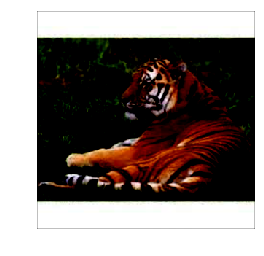

In [87]:
plot_image = test_images[10,:,:,:]

plt.imshow(plot_image)
plt.axis("off")
plt.show()

Exercise: Download the latest pretrained Inception v3 model: the checkpoint is available at https://github.com/tensorflow/models/tree/master/research/slim. The list of class names is available at https://goo.gl/brXRtZ, but you must insert a "background" class at the beginning.

In [62]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [63]:
fetch_pretrained_inception_v3()

In [64]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception","imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [65]:
class_names = ["background"] + load_class_names()

In [66]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

Exercise: Create the Inception v3 model by calling the inception_v3() function, as shown below. This must be done within an argument scope created by the inception_v3_arg_scope() function. Also, you must set is_training=False and num_classes=1001 [...]

In [67]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

Exercise: Open a session and use the Saver to restore the pretrained model checkpoint you downloaded earlier.

In [68]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


Run the model to classify the images you prepared. Display the top five predictions for each image, along with the estimated probability

In [73]:
X_test = test_images[:,:,:,:]

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [74]:
np.shape(predictions_val)

(11, 1001)

In [75]:
most_likely_class_index = np.argmax(predictions_val, axis=1)
most_likely_class_index

array([167, 351, 346, 372, 213, 338, 387, 362, 464,  11, 293])

In [77]:
for i in most_likely_class_index:
    print(class_names[i])

Walker hound, Walker foxhound
ibex, Capra ibex
ox
patas, hussar monkey, Erythrocebus patas
English setter
beaver
African elephant, Loxodonta africana
skunk, polecat, wood pussy
bucket, pail
brambling, Fringilla montifringilla
tiger, Panthera tigris


In [78]:
print(test_labels)

['goat', 'elk', 'cow', 'monkey', 'dog', 'vole', 'elephant', 'skunk', 'cat', 'bird', 'tiger']


In [90]:
for i in range(np.shape(predictions_val)[0]):
    print()
    print("Top 5 predictions for a picture of:")
    print(test_labels[i])
    print()
    top_5 = np.argpartition(predictions_val[i], -5)[-5:]
    top_5 = reversed(top_5[np.argsort(predictions_val[i][top_5])])
    for j in top_5:
        print("{0}: {1:.2f}%".format(class_names[j], 100*predictions_val[i][j]))
    


Top 5 predictions for a picture of:
goat

Walker hound, Walker foxhound: 16.28%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 13.96%
English foxhound: 7.57%
Great Dane: 5.66%
German short-haired pointer: 4.67%

Top 5 predictions for a picture of:
elk

ibex, Capra ibex: 46.43%
hartebeest: 15.87%
gazelle: 6.06%
bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis: 4.99%
impala, Aepyceros melampus: 1.59%

Top 5 predictions for a picture of:
cow

ox: 90.07%
sorrel: 1.99%
oxcart: 1.34%
gazelle: 0.35%
worm fence, snake fence, snake-rail fence, Virginia fence: 0.29%

Top 5 predictions for a picture of:
monkey

patas, hussar monkey, Erythrocebus patas: 63.32%
macaque: 14.91%
guenon, guenon monkey: 4.47%
langur: 2.13%
book jacket, dust cover, dust jacket, dust wrapper: 1.03%

Top 5 predictions for a picture of:
dog

English setter: 20.55%
English springer, English springer spaniel: 20.15%
Border co

## Retraining a large model

Exercise: Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can just use an existing dataset, such as the flowers dataset or MIT's places dataset (requires registration, and it is huge).

Let's tackle the flowers dataset. First, we need to download it:

In [94]:
import sys
import tarfile
from six.moves import urllib

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [96]:
fetch_flowers()

Downloading: 100%

In [97]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                        if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [100]:
#Get list of all the image file paths for each class:

from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

In [102]:
for paths in image_paths.values():
    paths.sort()
#sort paths to make sure notebook behaves consistently

Class: daisy


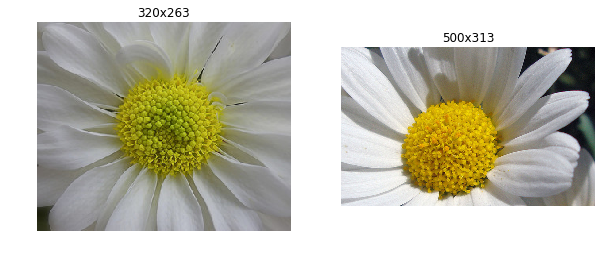

Class: dandelion


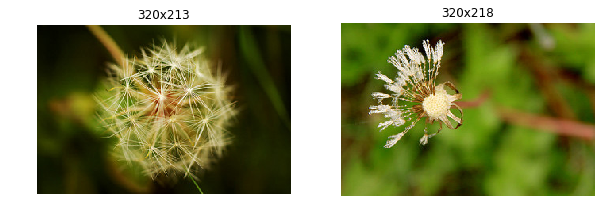

Class: roses


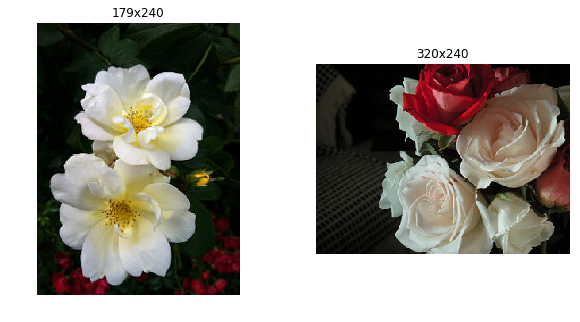

Class: sunflowers


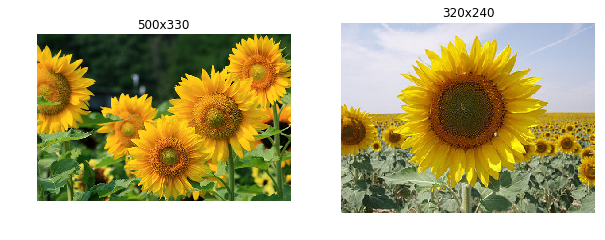

Class: tulips


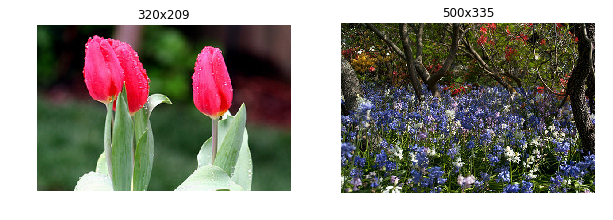

In [103]:
#Preview
channels = 3

import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("Class:", flower_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:,:,:channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

Write a preprocessing step that will resize and crop the image to 299 × 299, with some randomness for data augmentation.

First, let's implement this using NumPy and SciPy:

    using basic NumPy slicing for image cropping,
    NumPy's fliplr() function to flip the image horizontally (with 50% probability),
    and SciPy's imresize() function for zooming.
        Note that imresize() is based on the Python Image Library (PIL).

See SciPy documentation API

Also see  http://www.scipy-lectures.org/advanced/image_processing/

In [105]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""
    
    #First, find the largest bounding box with the target size ratio that fits within the image
    
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
    
    #Shrink this bounding box by a random factor
    
    #between 1.0 and 1.0 + 'max_zoom'
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    #Place bounding box on random location
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    #crop the image using the bounding box
    image = image[y0:y1, x0:x1]
    
    #Randomly flip half the images
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
        
    #resize the image to the target dimensions:
    image = imresize(image, (target_width, target_height))
    
    #colors must be represented as 32-bit floats ranging from 0.0 to 1.0:
    return image.astype(np.float32) / 255
    

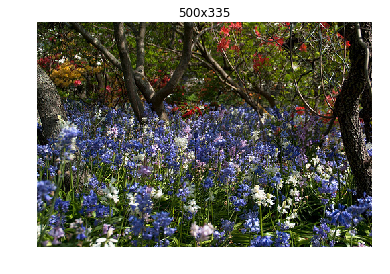

In [106]:
plt.figure(figsize=(6,8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

/home/mjlucker/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


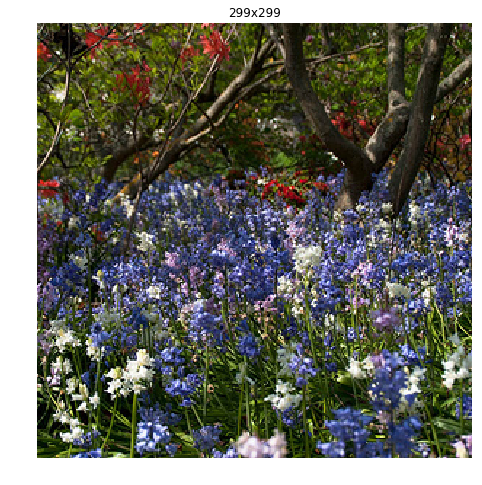

In [108]:
prepared_image = prepare_image(example_image)
plt.figure(figsize=(8,8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

/home/mjlucker/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


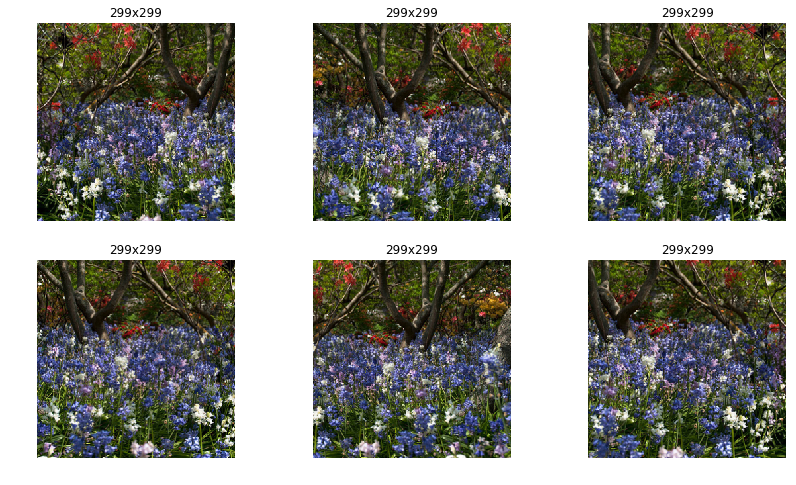

In [109]:
#look at how the augmentation is randomly generated

rows, cols = 2,3

plt.figure(figsize=(14,8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row*cols+col+1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

Alternatively, it's also possible to implement this image preprocessing step directly with TensorFlow, using the functions in the tf.image module (see the API for the full list). As you can see, this function looks very much like the one above, except it does not actually perform the image transformation, but rather creates a set of TensorFlow operations that will perform the transformation when you run the graph.

In [110]:
def prepare_image_with_tensorflow(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = tf.random_uniform(shape=[], minval=1.0, maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])   # 3 = number of channels

    # Let's crop the image using a random bounding box of the size we computed
    image = tf.random_crop(image, box_size)

    # Let's also flip the image horizontally with 50% probability:
    image = tf.image.random_flip_left_right(image)

    # The resize_bilinear function requires a 4D tensor (a batch of images)
    # so we need to expand the number of dimensions first:
    image_batch = tf.expand_dims(image, 0)

    # Finally, let's resize the image to the target dimensions. Note that this function
    # returns a float32 tensor.
    image_batch = tf.image.resize_bilinear(image_batch, [target_height, target_width])
    image = image_batch[0] / 255  # back to a single image, and scale the colors from 0.0 to 1.0
    return image

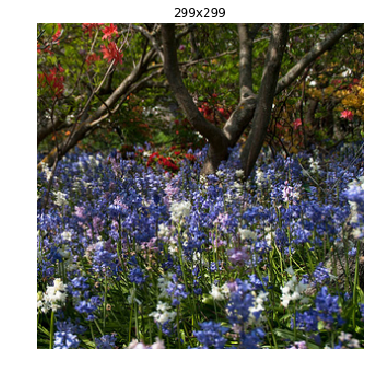

In [112]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = prepare_image_with_tensorflow(input_image)

with tf.Session():
    prepared_image = prepared_image_op.eval(feed_dict={input_image: example_image})
    
plt.figure(figsize=(6,6))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Exercise: Using the pretrained Inception v3 model from the previous exercise, freeze all layers up to the bottleneck layer (i.e., the last layer before the output layer), and replace the output layer with the appropriate number of outputs for your new classification task (e.g., the flowers dataset has five mutually exclusive classes so the output layer must have five neurons and use the softmax activation function).

Let's start by fetching the inception v3 graph again. This time, let's use a training placeholder that we will use to tell TensorFlow whether we are training the network or not (this is needed by operations such as dropout and batch normalization).


In [114]:
height, width = 299, 299
channels = 3

from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)
    
inception_saver = tf.train.Saver()

Now we need to find the point in the graph where we should attach the new output layer. It should be the layer right before the current output layer. One way to do this is to explore the output layer's inputs:

In [115]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

Nope, that's part of the output layer (adding the biases). Let's continue walking backwards in the graph:

In [116]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/Conv2D:0' shape=(?, 1, 1, 1001) dtype=float32>

That's also part of the output layer, it's the final layer in the inception layer (if you are not sure you can visualize the graph using TensorBoard). Once again, let's continue walking backwards in the graph:

In [117]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

Aha! There we are, this is the output of the dropout layer. This is the very last layer before the output layer in the Inception v3 network, so that's the layer we need to build upon. Note that there was actually a simpler way to find this layer: the inception_v3() function returns a dict of end points:

In [118]:
end_points

{'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=float32>,
 'Mixed_5b': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5b/concat:0' shape=(?, 35, 35, 256) dtype=float32>,
 'Mixed_5c': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5c/concat:0' shape=(?,

In [119]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

We can drop the 2nd and 3rd dimensions using the tf.squeeze() function:

In [120]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1,2])

In [121]:
prelogits

<tf.Tensor 'Squeeze:0' shape=(?, 2048) dtype=float32>

In [122]:
#Then add the final fully connected layer on top of this layer:

n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")



Finally, we need to add the usual bits and pieces:

    the placeholder for the targets (y),
    the loss function, which is the cross-entropy, as usual for a classification task,
    an optimizer, that we use to create a training operation that will minimize the cost function,
    a couple operations to measure the model's accuracy,
    and finally an initializer and a saver.

There is one important detail, however: since we want to train only the output layer (all other layers must be frozen), we must pass the list of variables to train to the optimizer's minimize() method:


In [123]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [124]:
[v.name for v in flower_vars]

['flower_logits/kernel:0', 'flower_logits/bias:0']



Notice that we created the inception_saver before adding the new output layer: we will use this saver to restore the pretrained model state, so we don't want it to try to restore new variables (it would just fail saying it does not know the new variables). The second saver will be used to save the final flower model, including both the pretrained variables and the new ones.


Exercise: Split your dataset into a training set and a test set. Train the model on the training set and evaluate it on the test set.

First, we will want to represent the classes as ints rather than strings:


In [125]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

It will be easier to shuffle the dataset set if we represent it as a list of filepath/class pairs:

In [126]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

In [127]:
#Next shuffle the dataset and split into the training set and the test set:

test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

In [129]:
#check instances:

flower_paths_and_classes_train[:6]

[('datasets/flowers/flower_photos/daisy/19834392829_7d697871f6.jpg', 0),
 ('datasets/flowers/flower_photos/sunflowers/5957007921_62333981d2_n.jpg', 3),
 ('datasets/flowers/flower_photos/tulips/7166635566_ee240b5408_n.jpg', 4),
 ('datasets/flowers/flower_photos/dandelion/3446018470_0c40e73ed6_m.jpg', 1),
 ('datasets/flowers/flower_photos/dandelion/3533075436_0954145b9f_m.jpg', 1),
 ('datasets/flowers/flower_photos/sunflowers/14741813010_5d44e33088_n.jpg', 3)]

Next, we will also need a function to preprocess a set of images. This function will be useful to preprocess the test set, and also to create batches during training. For simplicity, we will use the NumPy/SciPy implementation:

In [130]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:,:,:channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 #Inception expects colors ranging from -1.0 to 1.0
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [131]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)

/home/mjlucker/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [132]:
X_batch.shape

(4, 299, 299, 3)

In [133]:
X_batch.dtype

dtype('float32')

In [135]:
y_batch.shape

(4,)

In [136]:
y_batch.dtype

dtype('int32')

In [137]:
#Use function to prepare a test set
X_test, y_test = prepare_batch(flower_paths_and_classes_test, 
                              batch_size=len(flower_paths_and_classes_test))

/home/mjlucker/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [138]:
X_test.shape

(734, 299, 299, 3)



We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

And now, we are ready to train the network (or more precisely, the output layer we just added, since all the other layers are frozen). Be aware that this may take a (very) long time.


In [143]:
n_epochs = 80
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    
    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch, training: True})
            
        acc_train = accuracy.eval(feed_dict={X: X_batch, y:y_batch})
        print(" Train Accuracy:", acc_train)
        
        save_path = saver.save(sess, "./my_flowers_model")

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0.

/home/mjlucker/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


........................................................................ Train Accuracy: 0.55
Epoch 1......................................................................... Train Accuracy: 0.525
Epoch 2......................................................................... Train Accuracy: 0.7
Epoch 3......................................................................... Train Accuracy: 0.55
Epoch 4......................................................................... Train Accuracy: 0.7
Epoch 5......................................................................... Train Accuracy: 0.7
Epoch 6......................................................................... Train Accuracy: 0.8
Epoch 7......................................................................... Train Accuracy: 0.675
Epoch 8......................................................................... Train Accuracy: 0.7
Epoch 9......................................................................... Train Accura

Epoch 79......................................................................... Train Accuracy: 0.775


In [144]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")
    
    print("Computing final accuracy on the test set  . . . ")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y:y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model
Computing final accuracy on the test set  . . . 
Test accuracy: 0.67861897


If you have a GPU, you can try again and let training run for much longer (e.g., using early stopping to decide when to stop). You can also improve the image preprocessing function to make more tweaks to the image (e.g., changing the brightness and hue, rotate the image slightly). You can reach above 95% accuracy on this task. If you want to dig deeper, this great blog post goes into more details and reaches 96% accuracy.

https://kwotsin.github.io/tech/2017/02/11/transfer-learning.html